In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas
import numpy
import root_numpy
from rep.metaml import FoldingClassifier
from utils import shrink_floats

from utils import compute_labels_and_weights, compute_charges, names_labels_correspondence, labels_names_correspondence
from utils import plot_hist_features, roc_auc_score_one_vs_all
from utils import roc_auc_score_one_vs_all_for_separate_algorithms, compute_cvm_by_particle, plot_flatness_by_particle
import cPickle

## Read the data

In [3]:
data = pandas.DataFrame(root_numpy.root2array('../data/global_train.root', 'tree'))
shrink_floats(data)

In [4]:
data_test = pandas.DataFrame(root_numpy.root2array('../data/global_test.root', 'tree'))
shrink_floats(data_test)

In [ ]:
len(data)

In [6]:
data.head()

,VeloCharge,BremPIDe,CaloNeutralPrs,CaloNeutralSpd,InAccBrem,InAccSpd,CaloPrsE,InAccPrs,HcalPIDe,CaloHcalE,...,piplus_OWNPV_XERR,piplus_OWNPV_YERR,piplus_OWNPV_ZERR,piplus_OWNPV_CHI2,piplus_OWNPV_NDOF,piplus_IP_OWNPV,piplus_IPCHI2_OWNPV,nCandidate,totCandidates,EventInSequence
0,1.028090,-999,-999,-999,0,0,-999.000000,0,-999.000000,-999.000000,...,0.0096,0.0096,0.0532,33.816654,83,0.111340,15.622943,16,37,9099
1,1.044008,-999,-999,-999,0,0,-999.000000,0,-999.000000,-999.000000,...,0.0064,0.0063,0.0358,67.432457,187,0.025907,0.510528,38,106,12220
2,0.853933,-999,-999,-999,0,1,155.237808,1,-1.926180,27002.507812,...,0.0108,0.0108,0.0557,29.747982,67,0.136919,5.520920,14,76,8573
3,1.306180,-999,-999,-999,0,1,11.793685,1,0.434916,0.000000,...,0.0086,0.0084,0.0453,45.295311,97,0.572526,2.692502,25,50,13449
4,0.969101,-999,-999,-999,0,1,113.548508,1,1.788384,0.000000,...,0.0115,0.0110,0.0773,33.635342,71,0.101532,4.014179,24,86,1379


#### add signal column (from 0 to 5 classes), weights (to balance data), charges (to check assymetry)

In [7]:
data['Signal'], data['Weight'] = compute_labels_and_weights(data.MCParticleType.values)
data['Charge'] =  compute_charges(data.MCParticleType.values)

In [8]:
data_test['Signal'], data_test['Weight'] = compute_labels_and_weights(data_test.MCParticleType.values)
data_test['Charge'] =  compute_charges(data_test.MCParticleType.values)

#### check initial assymetry in data

In [9]:
print "positive tracks\t", numpy.mean(data.Charge > 0)
print "negative tracks\t", numpy.mean(data.Charge < 0)
print "GHOST tracks\t", numpy.mean(data.Charge == 0)

positive tracks	0.421249824791
negative tracks	0.412084147432
GHOST tracks	0.166666027777


In [10]:
print "positive tracks\t", numpy.mean(data_test.Charge > 0)
print "negative tracks\t", numpy.mean(data_test.Charge < 0)
print "GHOST tracks\t", numpy.mean(data_test.Charge == 0)

positive tracks	0.421374868958
negative tracks	0.411958519931
GHOST tracks	0.166666611111


#### weights

In [11]:
numpy.unique(data.Weight)

array([ 0.99989284,  0.99989484,  0.99989784,  0.99990384,  0.99990484,
        0.99990584])

#### number of tracks for each type

In [12]:
for key, val in names_labels_correspondence.items():
    print '{:10} \t'.format(key), sum(data.Signal == val)

Ghost      	999995
Electron   	1000004
Muon       	1000001
Pion       	1000006
Kaon       	999993
Proton     	999994


# Train, test splitting

In [13]:
from sklearn.cross_validation import train_test_split
train, test = train_test_split(data, train_size=0.50, random_state=19)

# Read features

In [14]:
import json
with open('./features.json', 'r') as f:
    features = json.load(f)
features_original = concatenate(features.values())
print len(features_original)

60


# Flatness experiments: DT with flatness loss (one versus all)

In [23]:
%%px

import sys
sys.path.insert(0, '/mnt/mfs/notebook/analyses/PID/antares')
from losses import BinFlatnessLossFunctionPercentile, SumFlatLossFunction
from losses import SumFlatLossFunctionSpeedup, OneDimensionalFlatnessLossFunction, AdaLossFunction

In [19]:
from losses import BinFlatnessLossFunctionPercentile, SumFlatLossFunction
from losses import SumFlatLossFunctionSpeedup, OneDimensionalFlatnessLossFunction, AdaLossFunction
from decisiontrain import DecisionTrainClassifier
from rep.estimators import SklearnClassifier
from utils import ClassifiersFactoryByClass

In [20]:
fl_coefficients = {'Electron': {'p': 5, 'pt': 5, 'p_pt': (5, 5), '2d': 5},
                   'Muon': {'p': 3, 'pt': 5, 'p_pt': (3, 5), '2d': 5},
                   'Ghost': {'p': 5, 'pt': 5, 'p_pt': (5, 5), '2d': 5},
                   'Proton': {'p': 5, 'pt': 5, 'p_pt': (5, 5), '2d': 5},
                   'Kaon': {'p': 5, 'pt': 5, 'p_pt': (5, 5), '2d': 5},
                   'Pion': {'p': 5, 'pt': 5, 'p_pt': (5, 5), '2d': 5}}

### track P flatness

In [24]:
%%time
flatness_p_dts = ClassifiersFactoryByClass()
for name, label in names_labels_correspondence.items():
    loss_p = BinFlatnessLossFunctionPercentile(uniform_features=['TrackP'], uniform_label=1, n_bins=100, 
                                               fl_coefficient=fl_coefficients[name]['p'])
    flatness_p_dts[name] = SklearnClassifier(DecisionTrainClassifier(n_threads=4, loss=loss_p,
                                             n_estimators=10000, learning_rate=0.05, train_features=features_original))
flatness_p_dts.fit(train, train.Signal.values, parallel_profile='ssh-py2')
with open('models/dt_flat_p.pkl', 'w') as f:
    cPickle.dump(flatness_p_dts, f)

model Ghost        was trained in 2691.36 seconds
model Electron     was trained in 2623.40 seconds
model Muon         was trained in 3018.03 seconds
model Pion         was trained in 3034.64 seconds
model Kaon         was trained in 3030.58 seconds
model Proton       was trained in 2672.58 seconds
Totally spent 3059.53 seconds on training
CPU times: user 1min 21s, sys: 23.5 s, total: 1min 45s
Wall time: 52min 17s


In [25]:
%%time
flatness_p_dts_speed = ClassifiersFactoryByClass()
for name, label in names_labels_correspondence.items():
    loss_p = SumFlatLossFunctionSpeedup(AdaLossFunction(), 
                                        OneDimensionalFlatnessLossFunction(uniform_features={'TrackP': 20.}, 
                                                                           uniform_label=1, n_bins=20))
    flatness_p_dts_speed[name] = SklearnClassifier(DecisionTrainClassifier(n_threads=4, loss=loss_p,
                                                   n_estimators=10000, learning_rate=0.05, 
                                                   train_features=features_original))
flatness_p_dts_speed.fit(train, train.Signal.values, parallel_profile='ssh-py2')
with open('models/dt_flat_p_speed.pkl', 'w') as f:
    cPickle.dump(flatness_p_dts_speed, f)

model Ghost        was trained in 2317.57 seconds
model Electron     was trained in 2209.43 seconds
model Muon         was trained in 2431.68 seconds
model Pion         was trained in 2465.58 seconds
model Kaon         was trained in 2404.28 seconds
model Proton       was trained in 2270.22 seconds
Totally spent 2489.45 seconds on training
CPU times: user 58.4 s, sys: 20.9 s, total: 1min 19s
Wall time: 42min 20s


In [30]:
preds_p = {}
for label, cl in flatness_p_dts.items():
    preds_p[names_labels_correspondence[label]] = cl.predict_proba(data_test)[:, 1]
    
roc_auc_score_one_vs_all_for_separate_algorithms(data_test.Signal.values, preds_p, 
                                                 sample_weight=data_test.Weight)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.961455,0.989839,0.989043,0.95186,0.916293,0.919232


In [31]:
preds_p_speed = {}
for label, cl in flatness_p_dts_speed.items():
    preds_p_speed[names_labels_correspondence[label]] = cl.predict_proba(data_test)[:, 1]
    
roc_auc_score_one_vs_all_for_separate_algorithms(data_test.Signal.values, preds_p_speed, 
                                                 sample_weight=data_test.Weight)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.961479,0.989993,0.988848,0.952674,0.91768,0.92071


In [23]:
# preds_p = {}
# for label, cl in flatness_p_dts.items():
#     preds_p[names_labels_correspondence[label]] = cl.predict_proba(data_test)[:, 1]
    
# roc_auc_score_one_vs_all_for_separate_algorithms(data_test.Signal.values, preds_p, 
#                                                  sample_weight=data_test.Weight)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.961486,0.989779,0.989243,0.951706,0.915504,0.919246


In [32]:
with open('models/flatness_p_probs.pkl', 'w') as f:
    cPickle.dump(preds_p, f)
with open('models/flatness_p_speed_probs.pkl', 'w') as f:
    cPickle.dump(preds_p_speed, f)

In [25]:
# from utils import compute_cvm_by_particle
# compute_cvm_by_particle(data_test.Signal.values, preds_p, 
#                         {'TrackP': data_test.TrackP.values, 'TrackPt': data_test.TrackPt.values})

,TrackP,TrackPt
Ghost,0.001618,0.007001
Electron,0.001152,0.025730
Muon,0.005456,0.018232
Pion,0.001853,0.010743
Kaon,0.002546,0.013865
Proton,0.002000,0.028587


In [34]:
from utils import compute_cvm_by_particle
compute_cvm_by_particle(data_test.Signal.values, preds_p, 
                        {'TrackP': data_test.TrackP.values, 'TrackPt': data_test.TrackPt.values})

,TrackP,TrackPt
Ghost,0.000987,0.006180
Electron,0.001146,0.025742
Muon,0.004930,0.017295
Pion,0.001789,0.010871
Kaon,0.010398,0.015782
Proton,0.002116,0.028759


In [33]:
compute_cvm_by_particle(data_test.Signal.values, preds_p_speed, 
                        {'TrackP': data_test.TrackP.values, 'TrackPt': data_test.TrackPt.values})

,TrackP,TrackPt
Ghost,0.001184,0.006740
Electron,0.001552,0.027178
Muon,0.004919,0.017492
Pion,0.002984,0.011458
Kaon,0.004465,0.014920
Proton,0.003607,0.030575


/moosefs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


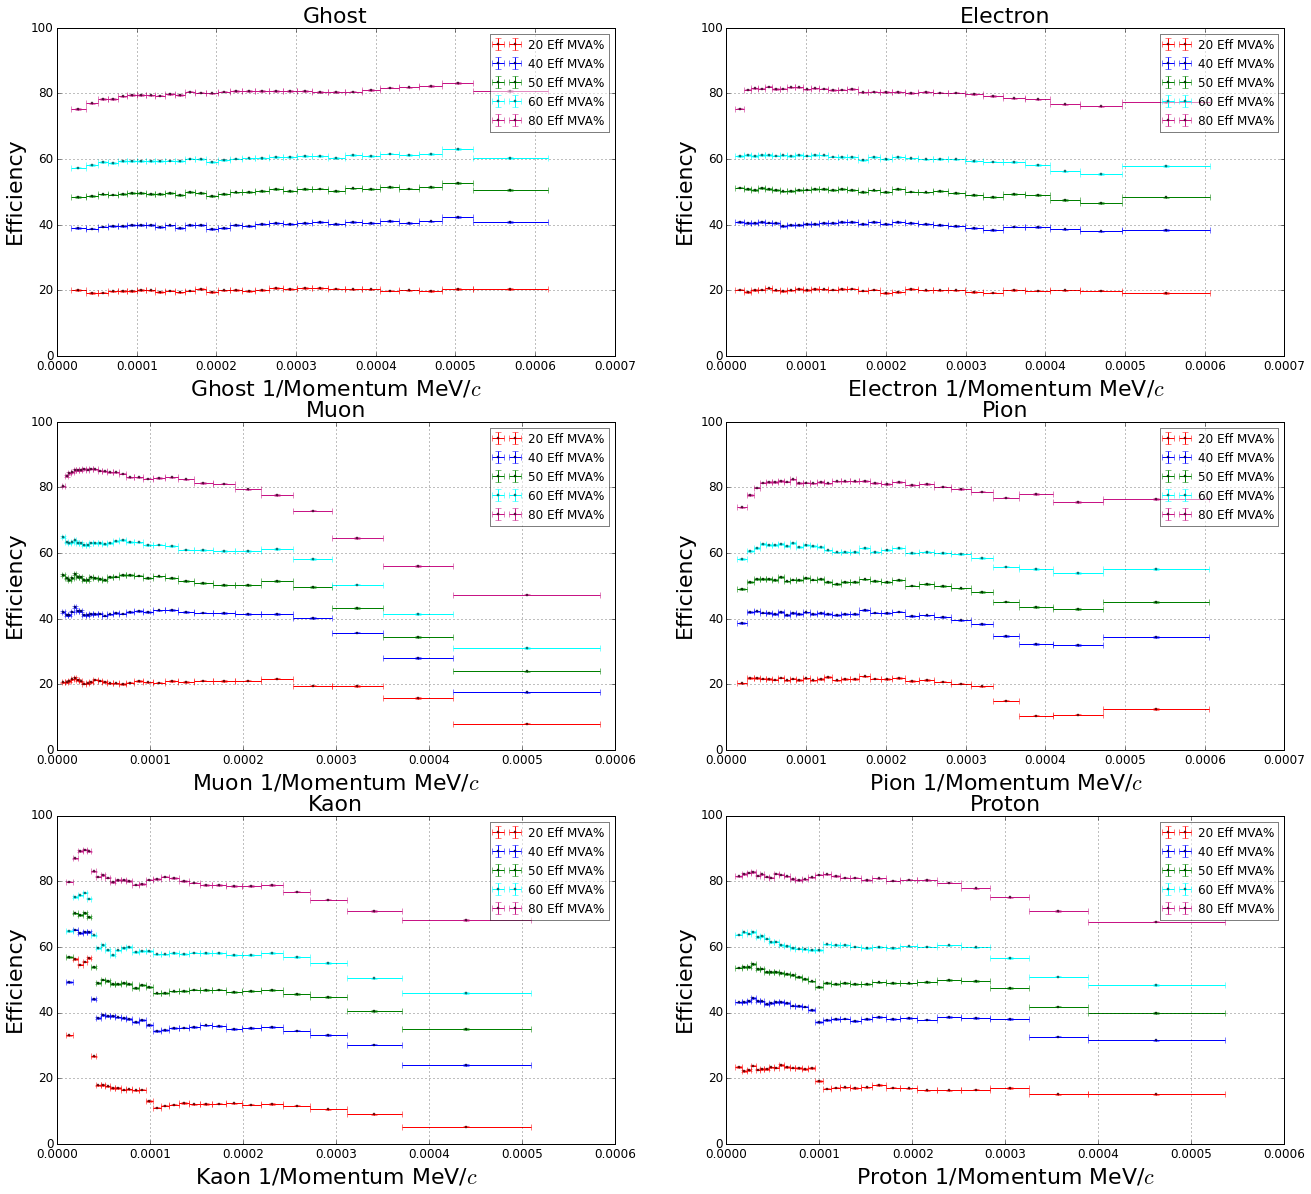

In [35]:
plot_flatness_by_particle(data_test.Signal.values, preds_p, 1./data_test.TrackP.values,
                          '1/Momentum MeV/$c$', thresholds=[20, 40, 50, 60, 80], weights=data_test.Weight.values, 
                          ignored_sideband=0.01)

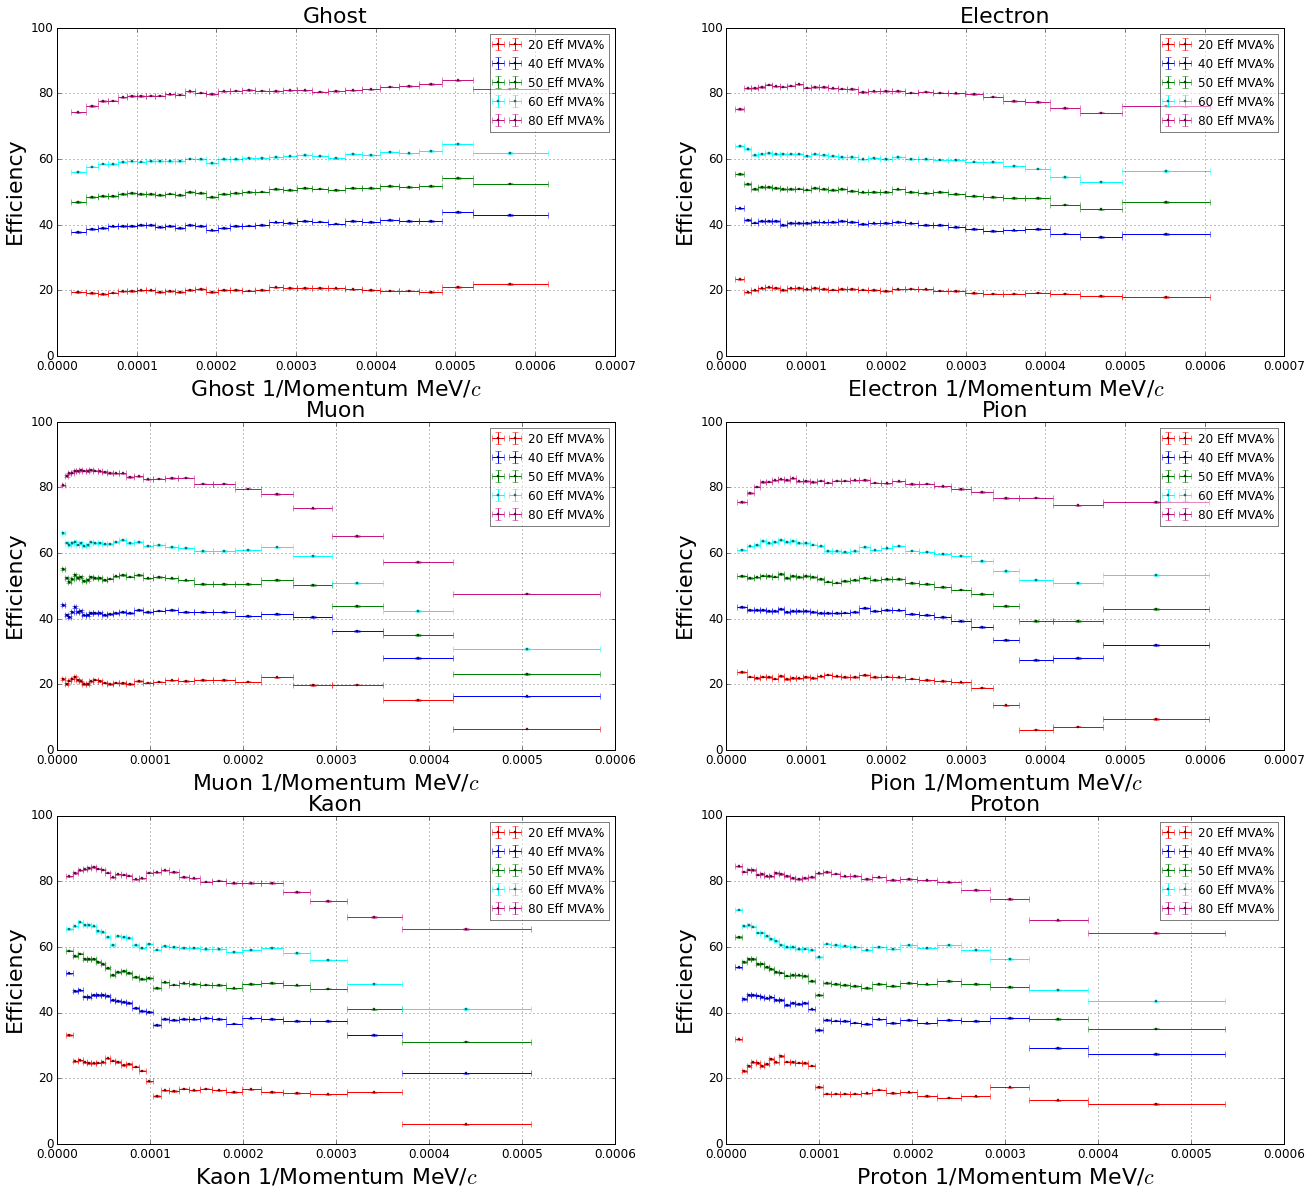

In [36]:
plot_flatness_by_particle(data_test.Signal.values, preds_p_speed, 1./data_test.TrackP.values,
                          '1/Momentum MeV/$c$', thresholds=[20, 40, 50, 60, 80], weights=data_test.Weight.values, 
                          ignored_sideband=0.01)

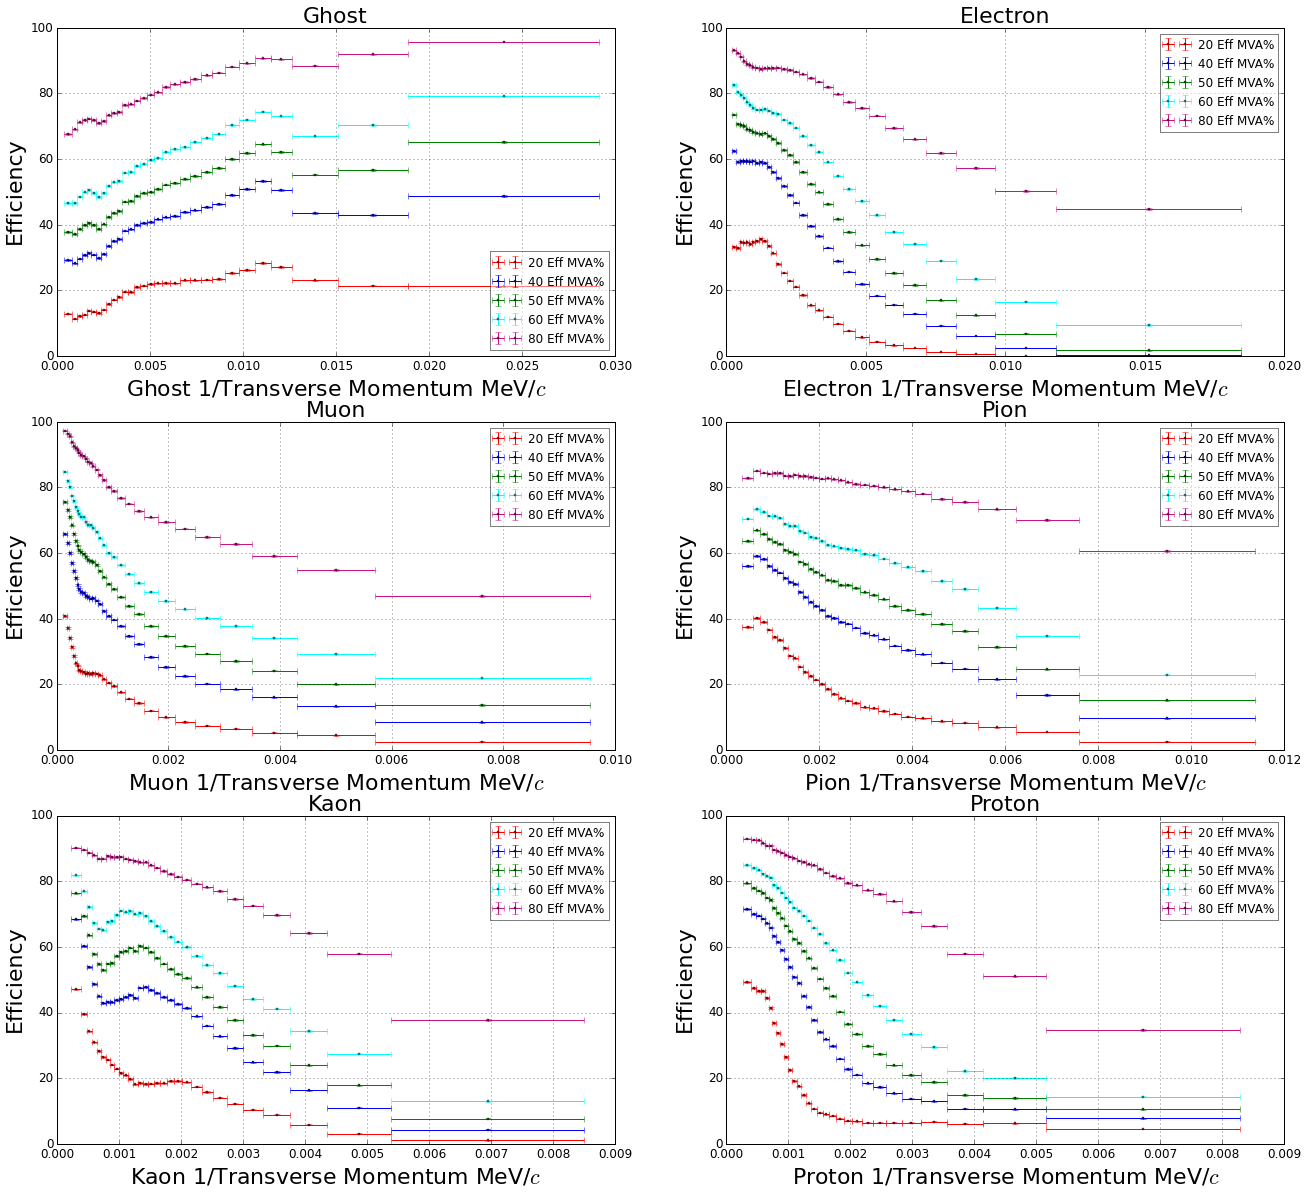

In [37]:
plot_flatness_by_particle(data_test.Signal.values, preds_p, 1./data_test.TrackPt.values,
                          '1/Transverse Momentum MeV/$c$', thresholds=[20, 40, 50, 60, 80], 
                          weights=data_test.Weight.values, 
                          ignored_sideband=0.01)

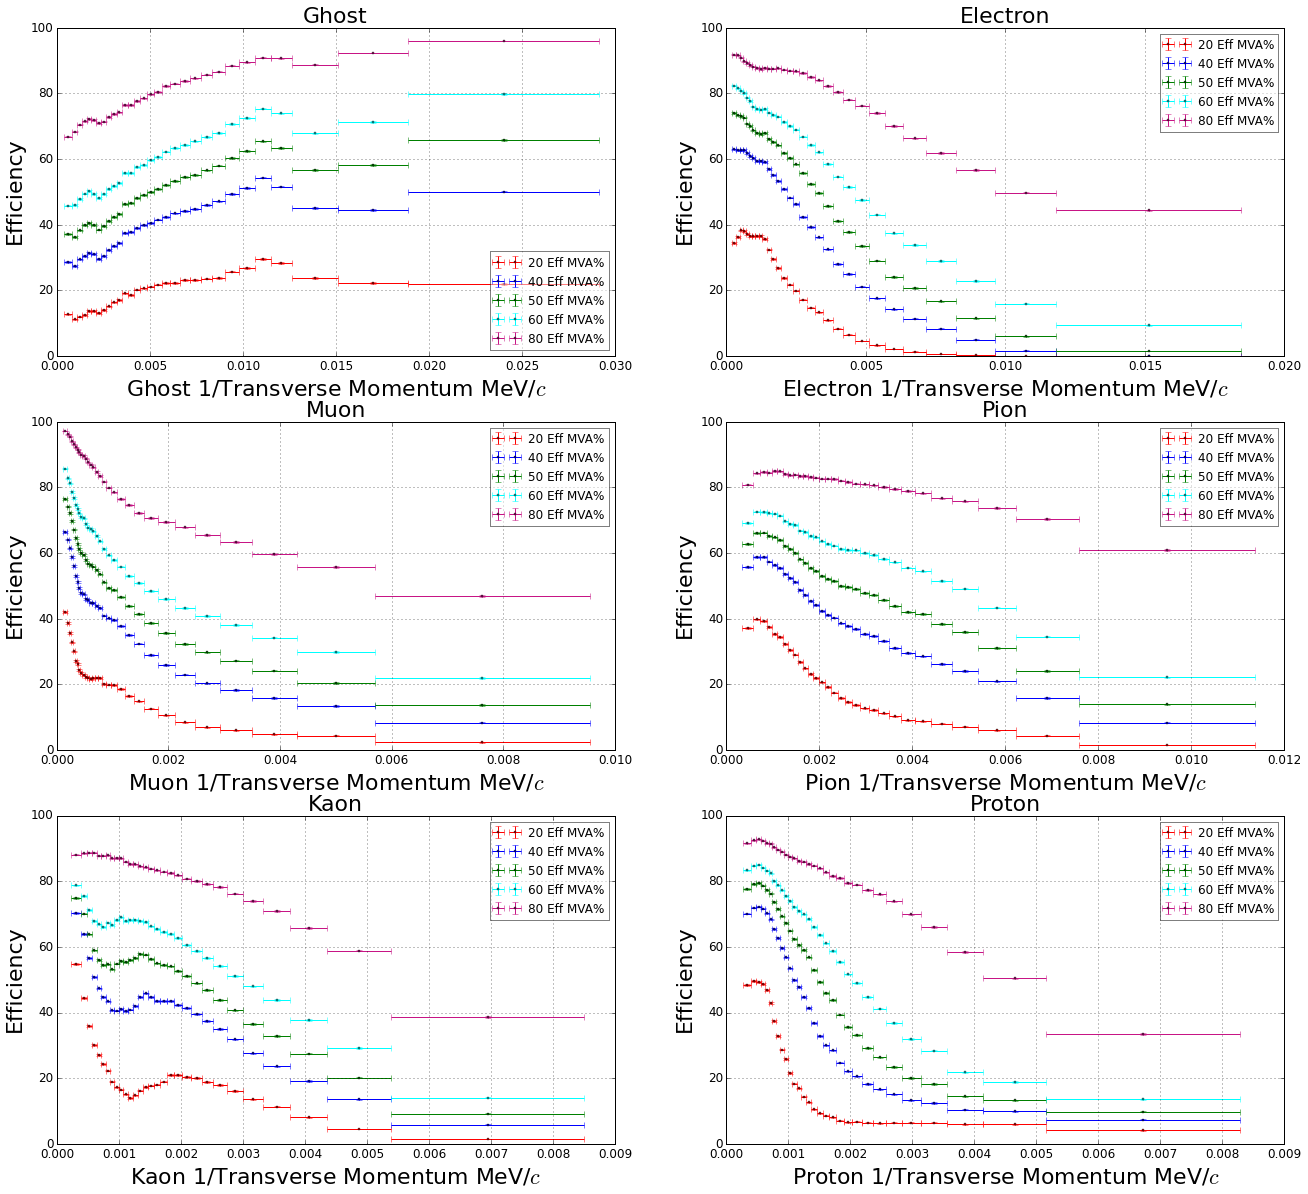

In [38]:
plot_flatness_by_particle(data_test.Signal.values, preds_p_speed, 1./data_test.TrackPt.values,
                          '1/Transverse Momentum MeV/$c$', thresholds=[20, 40, 50, 60, 80], 
                          weights=data_test.Weight.values, 
                          ignored_sideband=0.01)

### track Pt flatness

In [ ]:
%%time
flatness_pt_dts = ClassifiersFactoryByClass()
for name, label in names_labels_correspondence.items():
    loss_pt = BinFlatnessLossFunctionPercentile(uniform_features=['TrackPt'], uniform_label=1, n_bins=100, 
                                                fl_coefficient=fl_coefficients[name]['pt'])
    flatness_pt_dts[name] = SklearnClassifier(DecisionTrainClassifier(n_threads=4, loss=loss_pt,
                                              n_estimators=10000, learning_rate=0.05, train_features=features_original))
flatness_pt_dts.fit(train, train.Signal.values, parallel_profile='ssh-py2')
with open('models/dt_flat_pt.pkl', 'w') as f:
    cPickle.dump(flatness_pt_dts, f)

model Ghost        was trained in 2953.64 seconds
model Electron     was trained in 2656.02 seconds
model Muon         was trained in 3029.80 seconds
model Pion         was trained in 3023.21 seconds
model Kaon         was trained in 3056.26 seconds
model Proton       was trained in 2728.78 seconds
Totally spent 3084.78 seconds on training
CPU times: user 1min 21s, sys: 23.5 s, total: 1min 45s
Wall time: 52min 44s


In [ ]:
%%time
flatness_pt_dts_speed = ClassifiersFactoryByClass()
for name, label in names_labels_correspondence.items():
    loss_pt = SumFlatLossFunctionSpeedup(AdaLossFunction(), 
                                         OneDimensionalFlatnessLossFunction(uniform_features={'TrackPt': 20.}, 
                                                                            uniform_label=1, n_bins=20))
    flatness_pt_dts_speed[name] = SklearnClassifier(DecisionTrainClassifier(n_threads=4, loss=loss_pt,
                                                    n_estimators=10000, learning_rate=0.05, 
                                                    train_features=features_original))
flatness_pt_dts_speed.fit(train, train.Signal.values, parallel_profile='ssh-py2')
with open('models/dt_flat_pt_speed.pkl', 'w') as f:
    cPickle.dump(flatness_pt_dts_speed, f)

model Ghost        was trained in 2273.74 seconds
model Electron     was trained in 2197.45 seconds
model Muon         was trained in 2571.20 seconds
model Pion         was trained in 2620.99 seconds
model Kaon         was trained in 2632.26 seconds
model Proton       was trained in 2259.73 seconds
Totally spent 2661.11 seconds on training
CPU times: user 59.6 s, sys: 21.8 s, total: 1min 21s
Wall time: 45min 10s


In [39]:
preds_pt = {}
for label, cl in flatness_pt_dts.items():
    preds_pt[names_labels_correspondence[label]] = cl.predict_proba(data_test)[:, 1]
    
with open('models/flatness_pt_probs.pkl', 'w') as f:
    cPickle.dump(preds_pt, f)

In [40]:
preds_pt_speed = {}
for label, cl in flatness_pt_dts_speed.items():
    preds_pt_speed[names_labels_correspondence[label]] = cl.predict_proba(data_test)[:, 1]
    
with open('models/flatness_pt_speed_probs.pkl', 'w') as f:
    cPickle.dump(preds_pt_speed, f)

In [41]:
roc_auc_score_one_vs_all_for_separate_algorithms(data_test.Signal.values, preds_pt, 
                                                 sample_weight=data_test.Weight)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.959987,0.987883,0.988941,0.953136,0.920122,0.91537


In [42]:
roc_auc_score_one_vs_all_for_separate_algorithms(data_test.Signal.values, preds_pt_speed, 
                                                 sample_weight=data_test.Weight)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.960269,0.988256,0.989719,0.9536,0.921707,0.917579


In [33]:
# roc_auc_score_one_vs_all_for_separate_algorithms(data_test.Signal.values, preds_pt, 
#                                                  sample_weight=data_test.Weight)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.96032,0.987822,0.9891,0.952961,0.920016,0.91522


In [43]:
compute_cvm_by_particle(data_test.Signal.values, preds_pt, 
                        {'TrackP': data_test.TrackP.values, 'TrackPt': data_test.TrackPt.values})

,TrackP,TrackPt
Ghost,0.001339,0.001246
Electron,0.004341,0.001612
Muon,0.019574,0.002227
Pion,0.016180,0.001581
Kaon,0.029595,0.002177
Proton,0.017089,0.002524


In [44]:
compute_cvm_by_particle(data_test.Signal.values, preds_pt_speed, 
                        {'TrackP': data_test.TrackP.values, 'TrackPt': data_test.TrackPt.values})

,TrackP,TrackPt
Ghost,0.001290,0.001741
Electron,0.003928,0.002329
Muon,0.019776,0.003198
Pion,0.016907,0.002214
Kaon,0.031677,0.003217
Proton,0.019083,0.003777


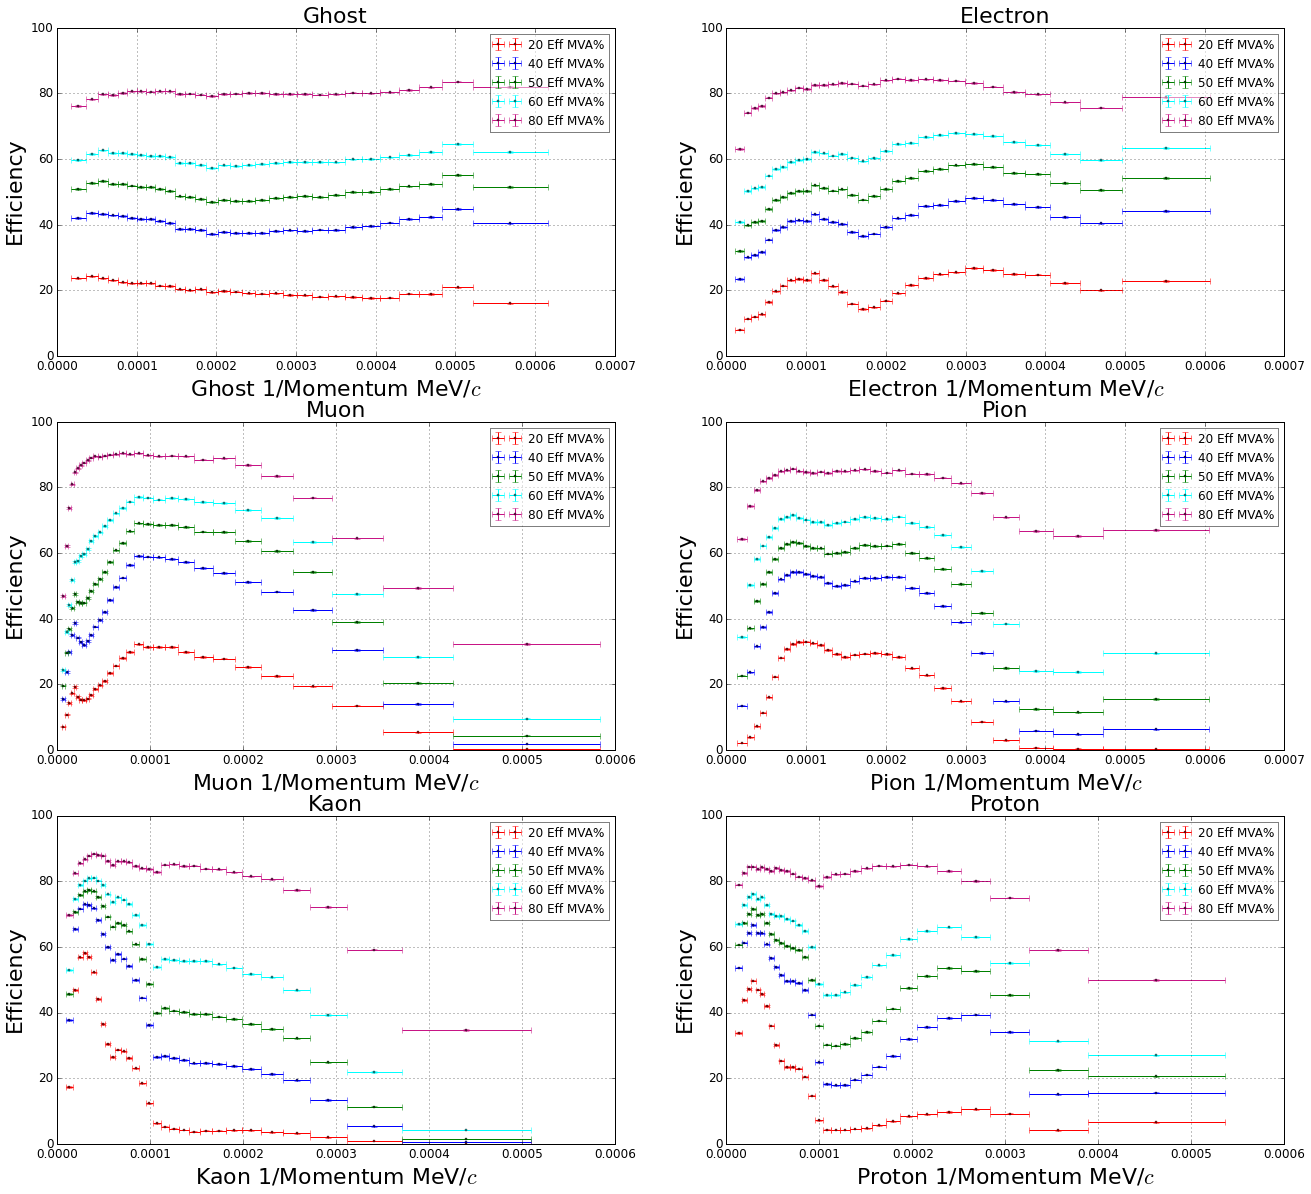

In [45]:
plot_flatness_by_particle(data_test.Signal.values, preds_pt, 1./data_test.TrackP.values,
                          '1/Momentum MeV/$c$', thresholds=[20, 40, 50, 60, 80], weights=data_test.Weight.values, 
                          ignored_sideband=0.01)

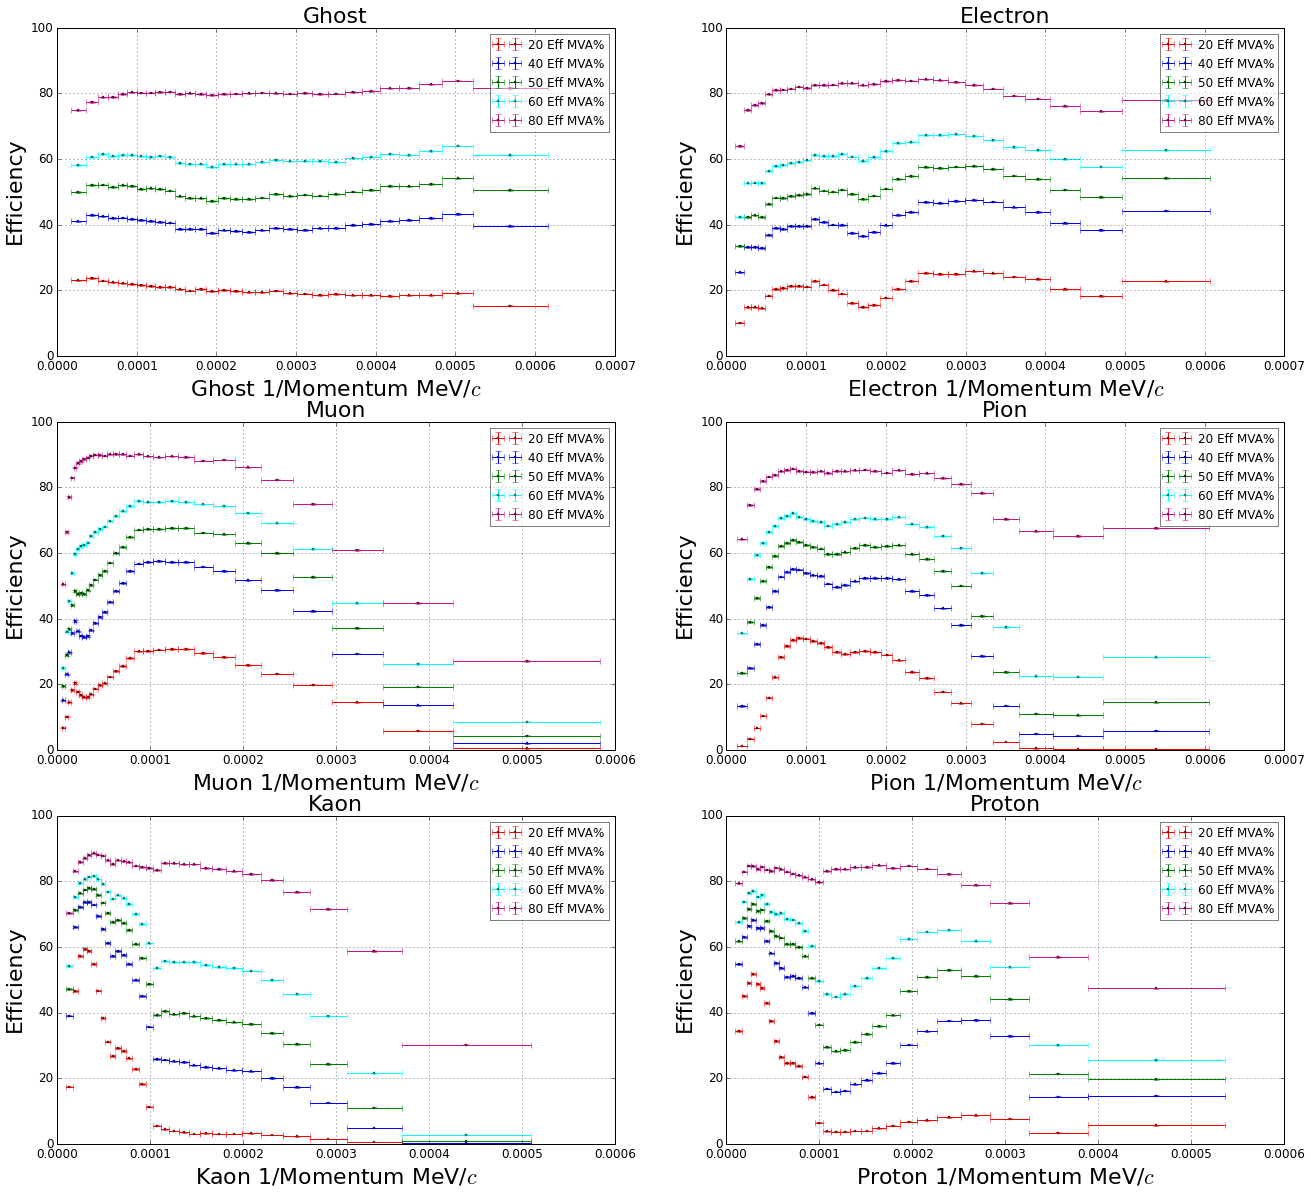

In [46]:
plot_flatness_by_particle(data_test.Signal.values, preds_pt_speed, 1./data_test.TrackP.values,
                          '1/Momentum MeV/$c$', thresholds=[20, 40, 50, 60, 80], weights=data_test.Weight.values, 
                          ignored_sideband=0.01)

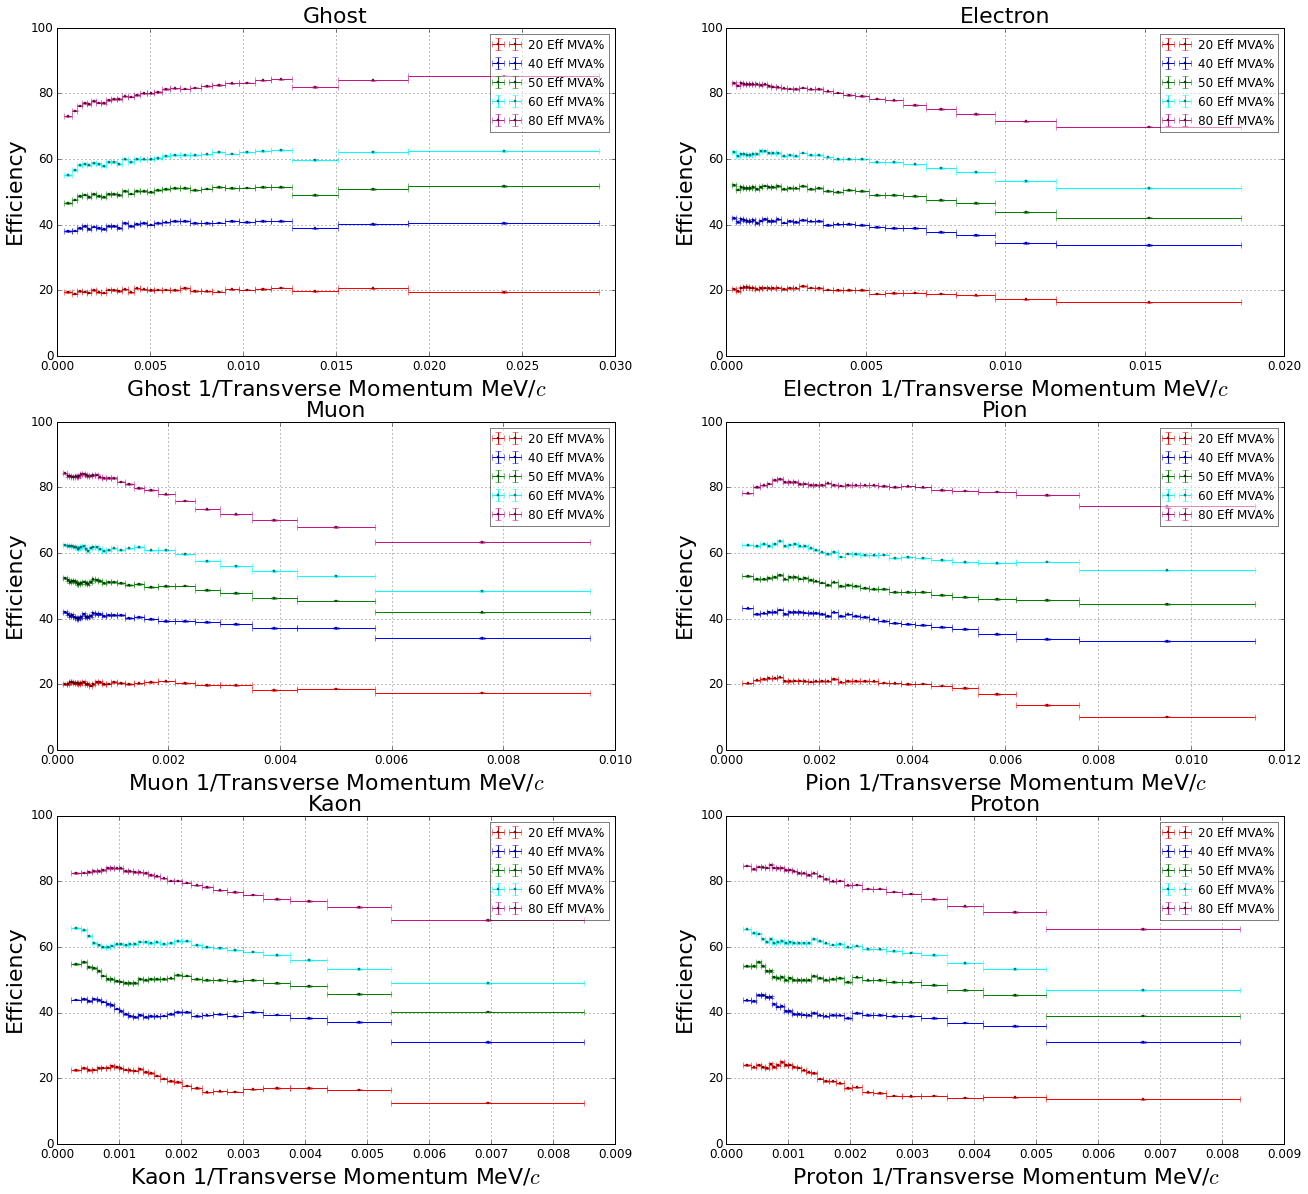

In [47]:
plot_flatness_by_particle(data_test.Signal.values, preds_pt, 1./data_test.TrackPt.values,
                          '1/Transverse Momentum MeV/$c$', thresholds=[20, 40, 50, 60, 80], 
                          weights=data_test.Weight.values, 
                          ignored_sideband=0.01)

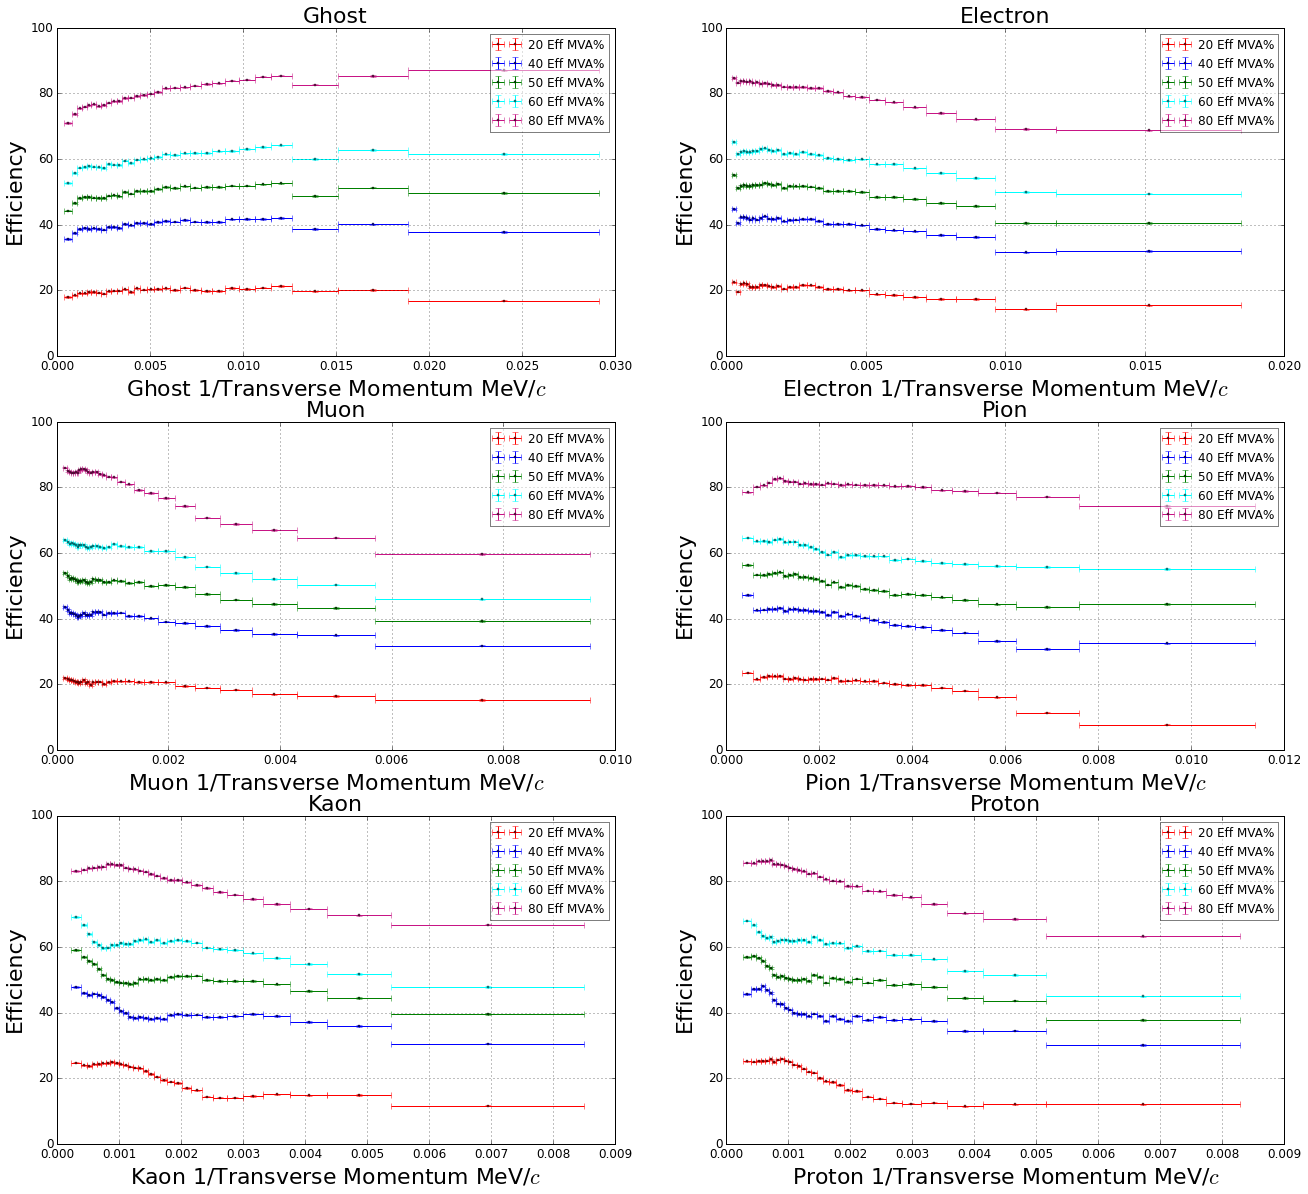

In [48]:
plot_flatness_by_particle(data_test.Signal.values, preds_pt_speed, 1./data_test.TrackPt.values,
                          '1/Transverse Momentum MeV/$c$', thresholds=[20, 40, 50, 60, 80], 
                          weights=data_test.Weight.values, 
                          ignored_sideband=0.01)

## Track P, Track Pt linear combination flatness

In [ ]:
%%time
flatness_p_pt_dts = ClassifiersFactoryByClass()
for name, label in names_labels_correspondence.items():
    fl_coeff = fl_coefficients[name]['p_pt']
    loss_linear_combination = SumFlatLossFunction(
        BinFlatnessLossFunctionPercentile(uniform_features=['TrackPt'], uniform_label=1, 
                                          n_bins=100, fl_coefficient=fl_coeff[1]),
        BinFlatnessLossFunctionPercentile(uniform_features=['TrackP'], uniform_label=1, 
                                          n_bins=100, fl_coefficient=fl_coeff[0]))

    flatness_p_pt_dts[name] = SklearnClassifier(DecisionTrainClassifier(n_threads=4, loss=loss_linear_combination,
                                                n_estimators=10000, learning_rate=0.05, 
                                                train_features=features_original))
flatness_p_pt_dts.fit(train, train.Signal.values, parallel_profile='ssh-py2')
with open('models/dt_flat_p_pt.pkl', 'w') as f:
    cPickle.dump(flatness_p_pt_dts, f)

model Ghost        was trained in 4693.76 seconds
model Electron     was trained in 4497.01 seconds
model Muon         was trained in 4657.05 seconds
model Pion         was trained in 4694.19 seconds
model Kaon         was trained in 4674.26 seconds
model Proton       was trained in 4262.20 seconds
Totally spent 4726.54 seconds on training
CPU times: user 2min 9s, sys: 27.4 s, total: 2min 36s
Wall time: 1h 21min 7s


In [ ]:
%%time
flatness_p_pt_dts_speed = ClassifiersFactoryByClass()
for name, label in names_labels_correspondence.items():
    loss_p_pt = SumFlatLossFunctionSpeedup(AdaLossFunction(), 
                                           OneDimensionalFlatnessLossFunction(uniform_features={'TrackPt': 20., 
                                                                                                'TrackP': 20.}, 
                                                                              uniform_label=1, n_bins=20))
    flatness_p_pt_dts_speed[name] = SklearnClassifier(DecisionTrainClassifier(n_threads=4, loss=loss_p_pt,
                                                      n_estimators=10000, learning_rate=0.05, 
                                                      train_features=features_original))
flatness_p_pt_dts_speed.fit(train, train.Signal.values, parallel_profile='ssh-py2')
with open('models/dt_flat_p_pt_speed.pkl', 'w') as f:
    cPickle.dump(flatness_p_pt_dts_speed, f)

model Ghost        was trained in 2604.88 seconds
model Electron     was trained in 2510.86 seconds
model Muon         was trained in 2760.47 seconds
model Pion         was trained in 2736.76 seconds
model Kaon         was trained in 2718.27 seconds
model Proton       was trained in 2540.07 seconds
Totally spent 2780.02 seconds on training
CPU times: user 1min 4s, sys: 22.6 s, total: 1min 27s
Wall time: 47min 17s


In [49]:
preds_p_pt = {}
for label, cl in flatness_p_pt_dts.items():
    preds_p_pt[names_labels_correspondence[label]] = cl.predict_proba(data_test)[:, 1]
    
with open('models/flatness_p_pt_probs.pkl', 'w') as f:
    cPickle.dump(preds_p_pt, f)

In [50]:
preds_p_pt_speed = {}
for label, cl in flatness_p_pt_dts_speed.items():
    preds_p_pt_speed[names_labels_correspondence[label]] = cl.predict_proba(data_test)[:, 1]
    
with open('models/flatness_p_pt_speed_probs.pkl', 'w') as f:
    cPickle.dump(preds_p_pt_speed, f)

In [45]:
# roc_auc_score_one_vs_all_for_separate_algorithms(data_test.Signal.values, preds_p_pt, 
#                                                  sample_weight=data_test.Weight)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.960501,0.988392,0.988734,0.951393,0.914501,0.913852


In [51]:
roc_auc_score_one_vs_all_for_separate_algorithms(data_test.Signal.values, preds_p_pt, 
                                                 sample_weight=data_test.Weight)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.960502,0.988363,0.988677,0.951421,0.914641,0.913997


In [52]:
roc_auc_score_one_vs_all_for_separate_algorithms(data_test.Signal.values, preds_p_pt_speed, 
                                                 sample_weight=data_test.Weight)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.960162,0.988072,0.987108,0.950949,0.913007,0.912472


In [53]:
compute_cvm_by_particle(data_test.Signal.values, preds_p_pt, 
                        {'TrackP': data_test.TrackP.values, 'TrackPt': data_test.TrackPt.values})

,TrackP,TrackPt
Ghost,0.000947,0.001635
Electron,0.001242,0.002539
Muon,0.005905,0.002642
Pion,0.002626,0.001904
Kaon,0.003977,0.002553
Proton,0.002924,0.003515


In [54]:
compute_cvm_by_particle(data_test.Signal.values, preds_p_pt_speed, 
                        {'TrackP': data_test.TrackP.values, 'TrackPt': data_test.TrackPt.values})

,TrackP,TrackPt
Ghost,0.000978,0.001740
Electron,0.001419,0.002259
Muon,0.003784,0.002108
Pion,0.002606,0.001785
Kaon,0.003789,0.002298
Proton,0.002937,0.002946


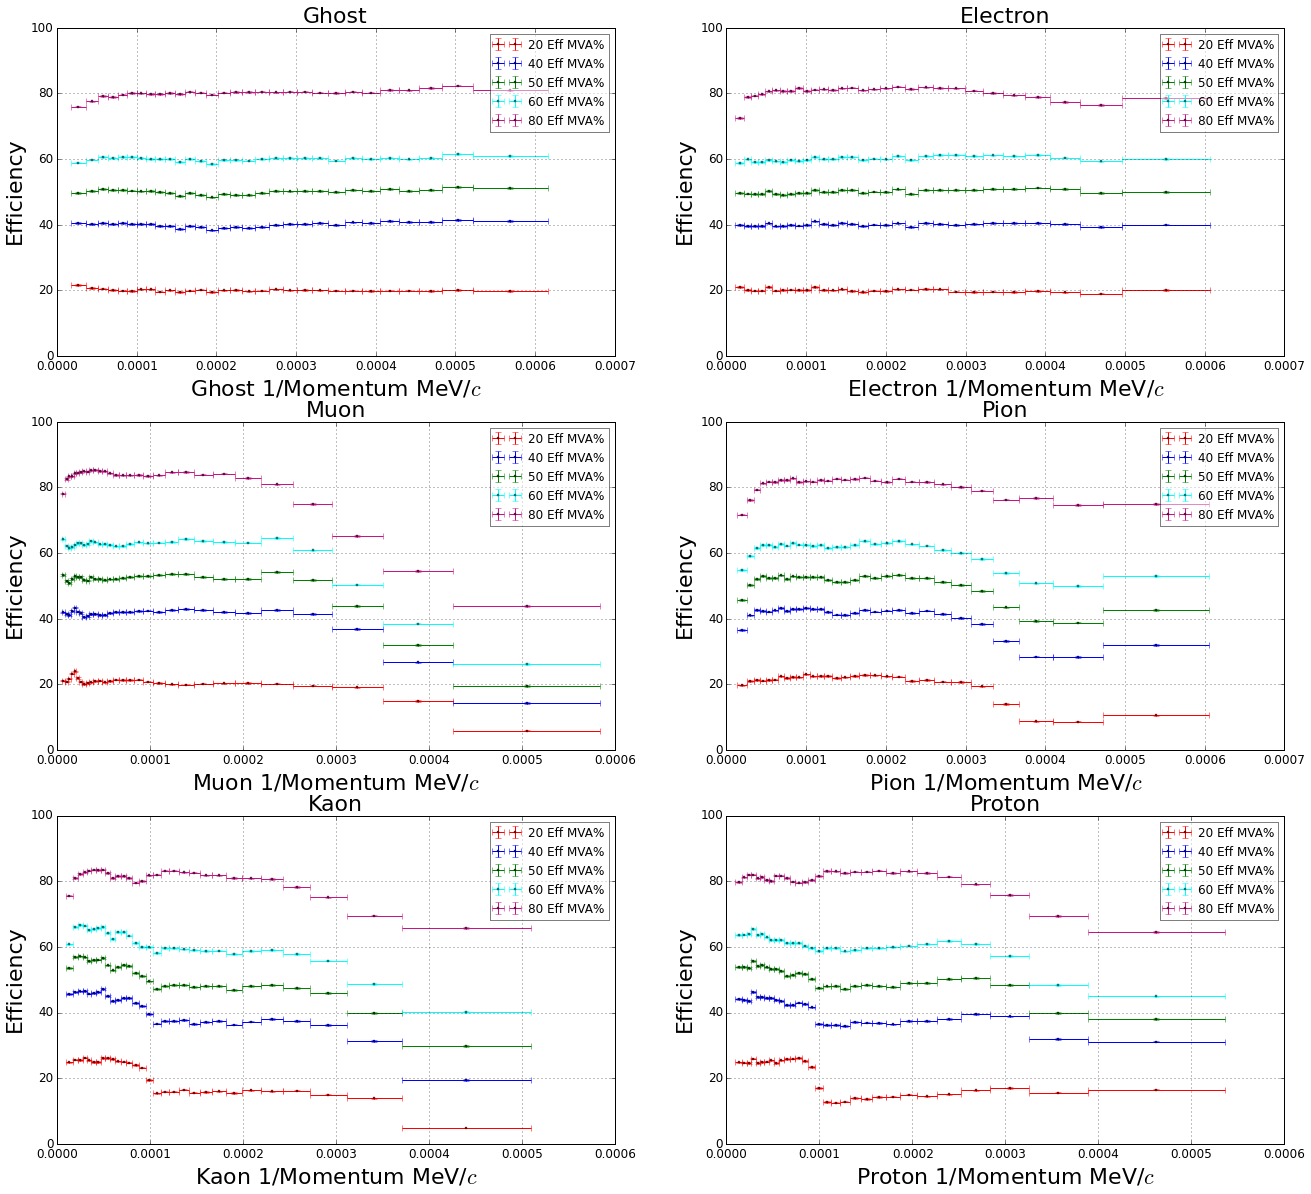

In [55]:
plot_flatness_by_particle(data_test.Signal.values, preds_p_pt, 1./data_test.TrackP.values,
                          '1/Momentum MeV/$c$', thresholds=[20, 40, 50, 60, 80], weights=data_test.Weight.values, 
                          ignored_sideband=0.01)

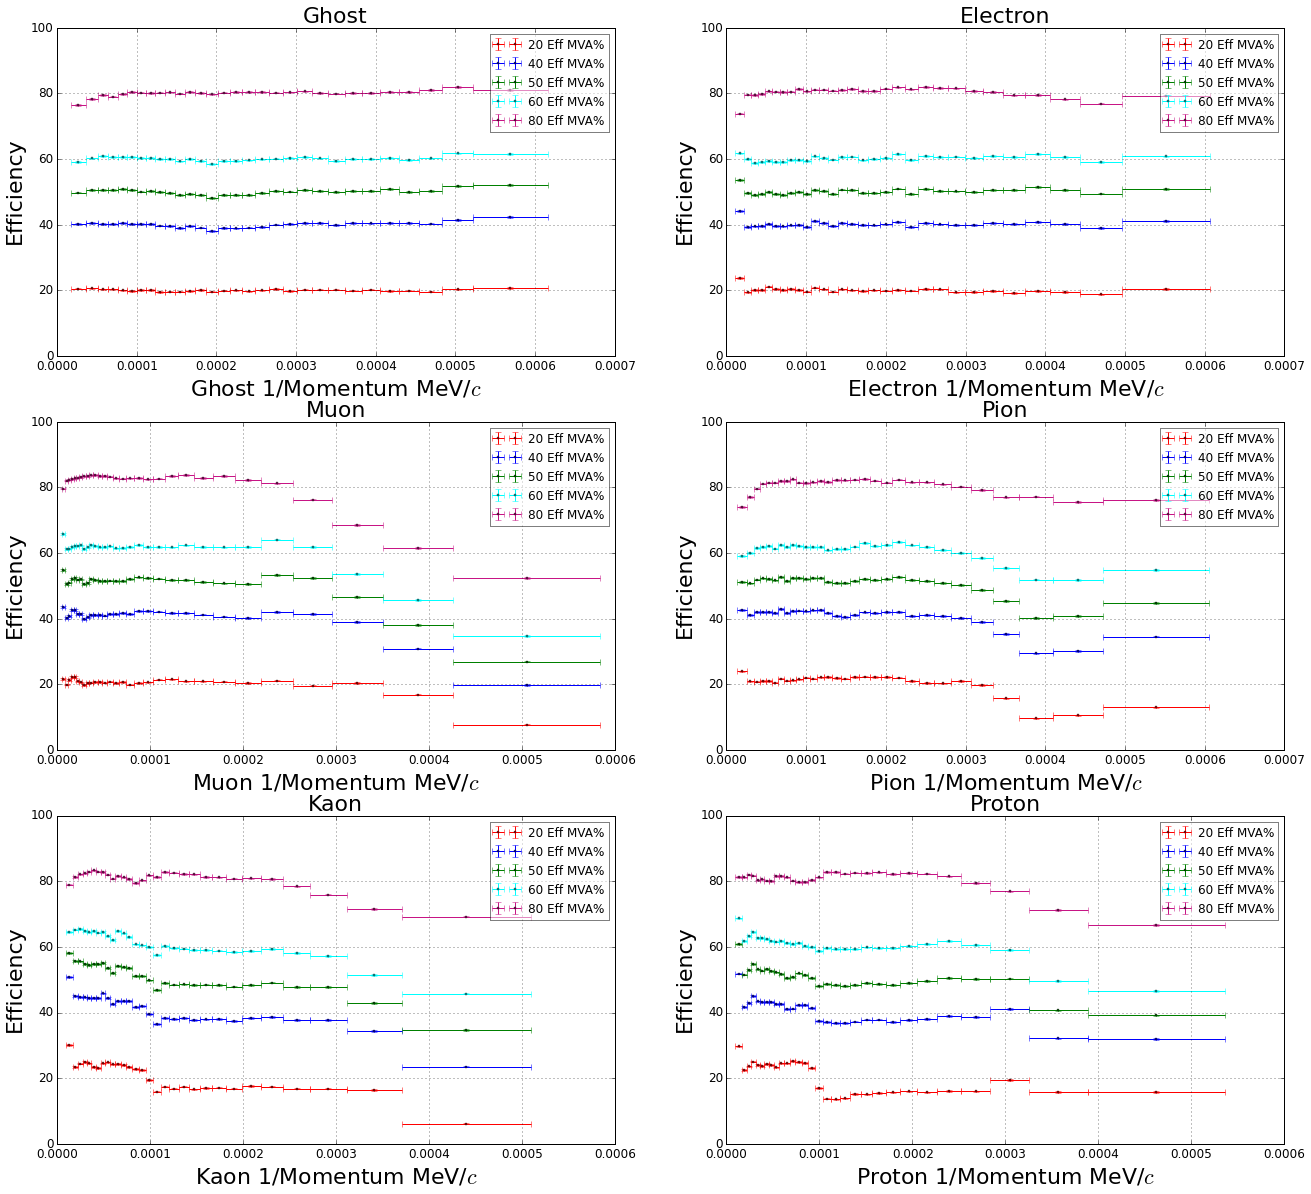

In [56]:
plot_flatness_by_particle(data_test.Signal.values, preds_p_pt_speed, 1./data_test.TrackP.values,
                          '1/Momentum MeV/$c$', thresholds=[20, 40, 50, 60, 80], weights=data_test.Weight.values, 
                          ignored_sideband=0.01)

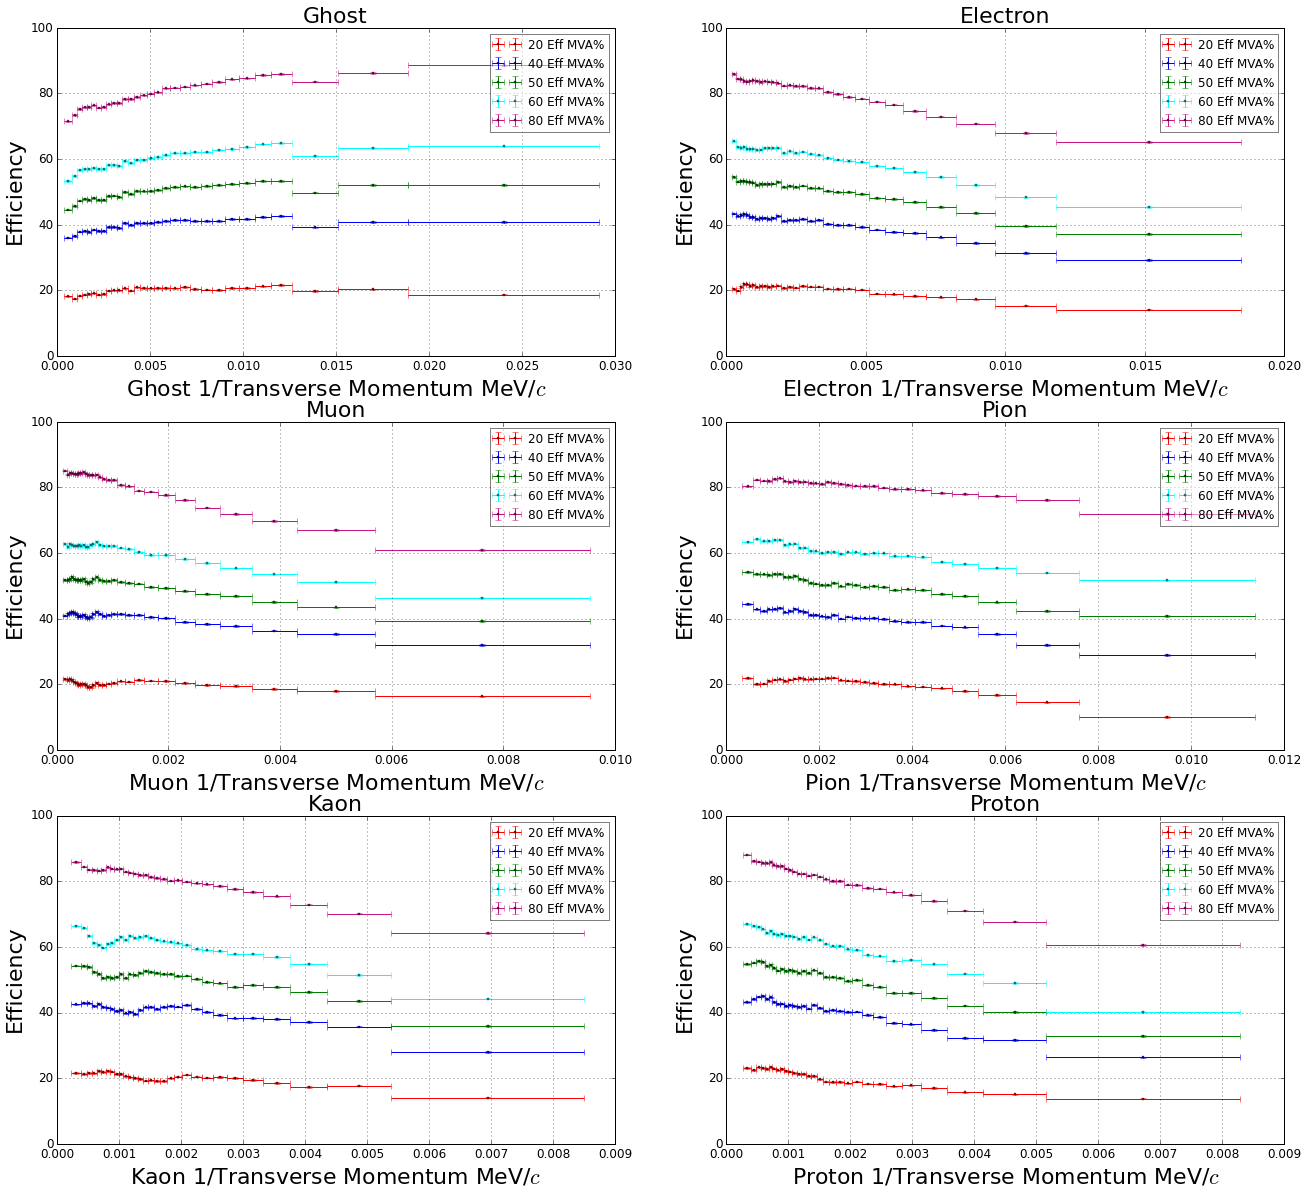

In [57]:
plot_flatness_by_particle(data_test.Signal.values, preds_p_pt, 1./data_test.TrackPt.values,
                          '1/Transverse Momentum MeV/$c$', thresholds=[20, 40, 50, 60, 80], 
                          weights=data_test.Weight.values, 
                          ignored_sideband=0.01)

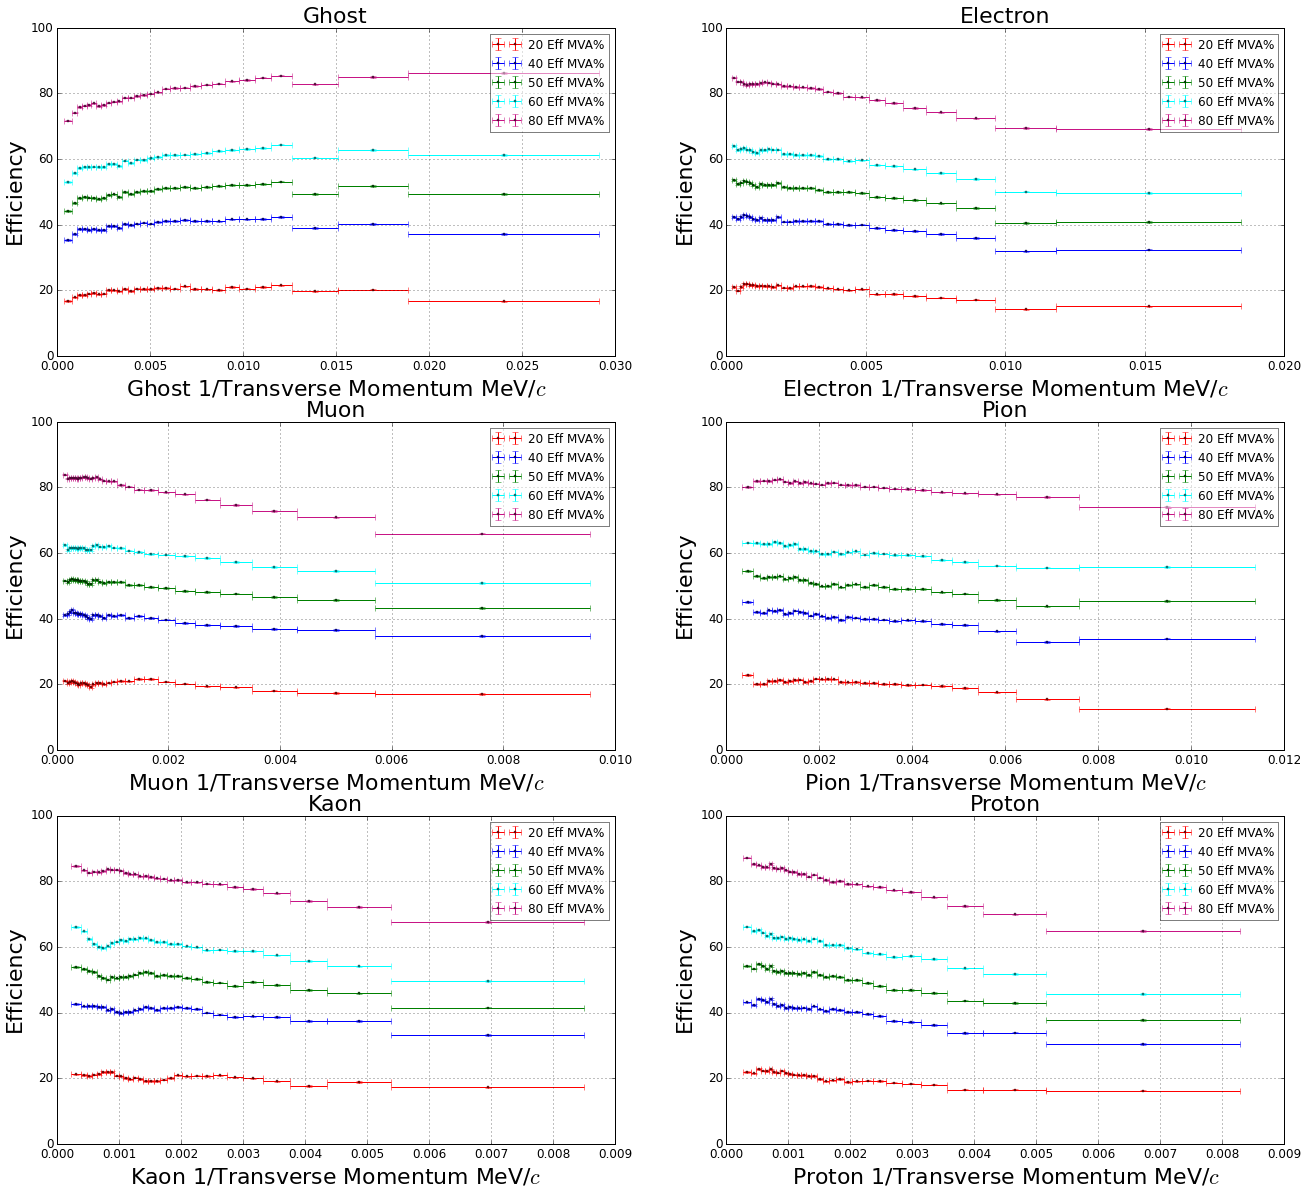

In [58]:
plot_flatness_by_particle(data_test.Signal.values, preds_p_pt_speed, 1./data_test.TrackPt.values,
                          '1/Transverse Momentum MeV/$c$', thresholds=[20, 40, 50, 60, 80], 
                          weights=data_test.Weight.values, 
                          ignored_sideband=0.01)

## 2d Flatness

In [ ]:
%%time
flatness_2d_dts = ClassifiersFactoryByClass()
for name, label in names_labels_correspondence.items():
    loss_2d = BinFlatnessLossFunctionPercentile(uniform_features=['TrackPt', 'TrackP'], uniform_label=1, n_bins=30, 
                                                fl_coefficient=fl_coefficients[name]['2d'])
    flatness_2d_dts[name] = SklearnClassifier(DecisionTrainClassifier(n_threads=4, loss=loss_2d,
                                              n_estimators=10000, learning_rate=0.05, train_features=features_original))
flatness_2d_dts.fit(train, train.Signal.values, parallel_profile='ssh-py2')
with open('models/flatness_2d_dts.pkl', 'w') as f:
    cPickle.dump(flatness_2d_dts, f)

In [60]:
preds_2d = {}
for label, cl in flatness_2d_dts.items():
    preds_2d[names_labels_correspondence[label]] = cl.predict_proba(data_test)[:, 1]
    
with open('models/flatness_2d_probs.pkl', 'w') as f:
    cPickle.dump(preds_2d, f)

In [61]:
roc_auc_score_one_vs_all_for_separate_algorithms(data_test.Signal.values, preds_2d, 
                                                 sample_weight=data_test.Weight)

,Ghost,Electron,Muon,Pion,Kaon,Proton
0,0.959409,0.986845,0.986543,0.949477,0.904911,0.899312


In [62]:
compute_cvm_by_particle(data_test.Signal.values, preds_2d, 
                        {'TrackP': data_test.TrackP.values, 'TrackPt': data_test.TrackPt.values})

,TrackP,TrackPt
Ghost,0.000951,0.001287
Electron,0.001361,0.001571
Muon,0.003378,0.002522
Pion,0.001986,0.001521
Kaon,0.005690,0.004676
Proton,0.004037,0.004534


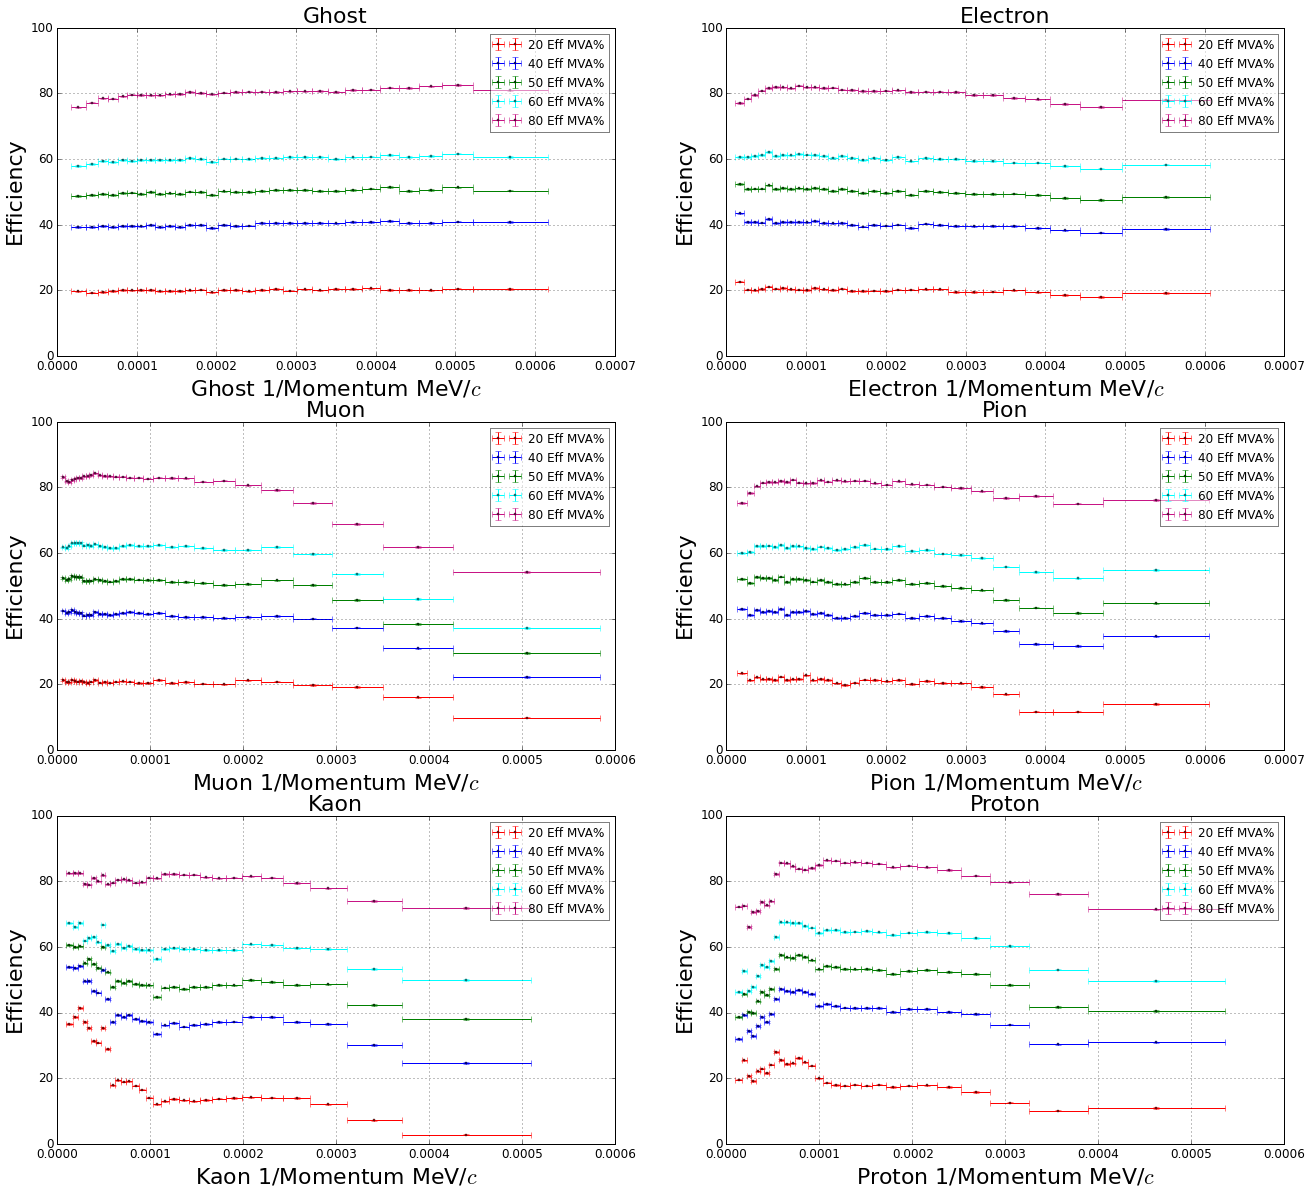

In [63]:
plot_flatness_by_particle(data_test.Signal.values, preds_2d, 1./data_test.TrackP.values,
                          '1/Momentum MeV/$c$', thresholds=[20, 40, 50, 60, 80], weights=data_test.Weight.values, 
                          ignored_sideband=0.01)

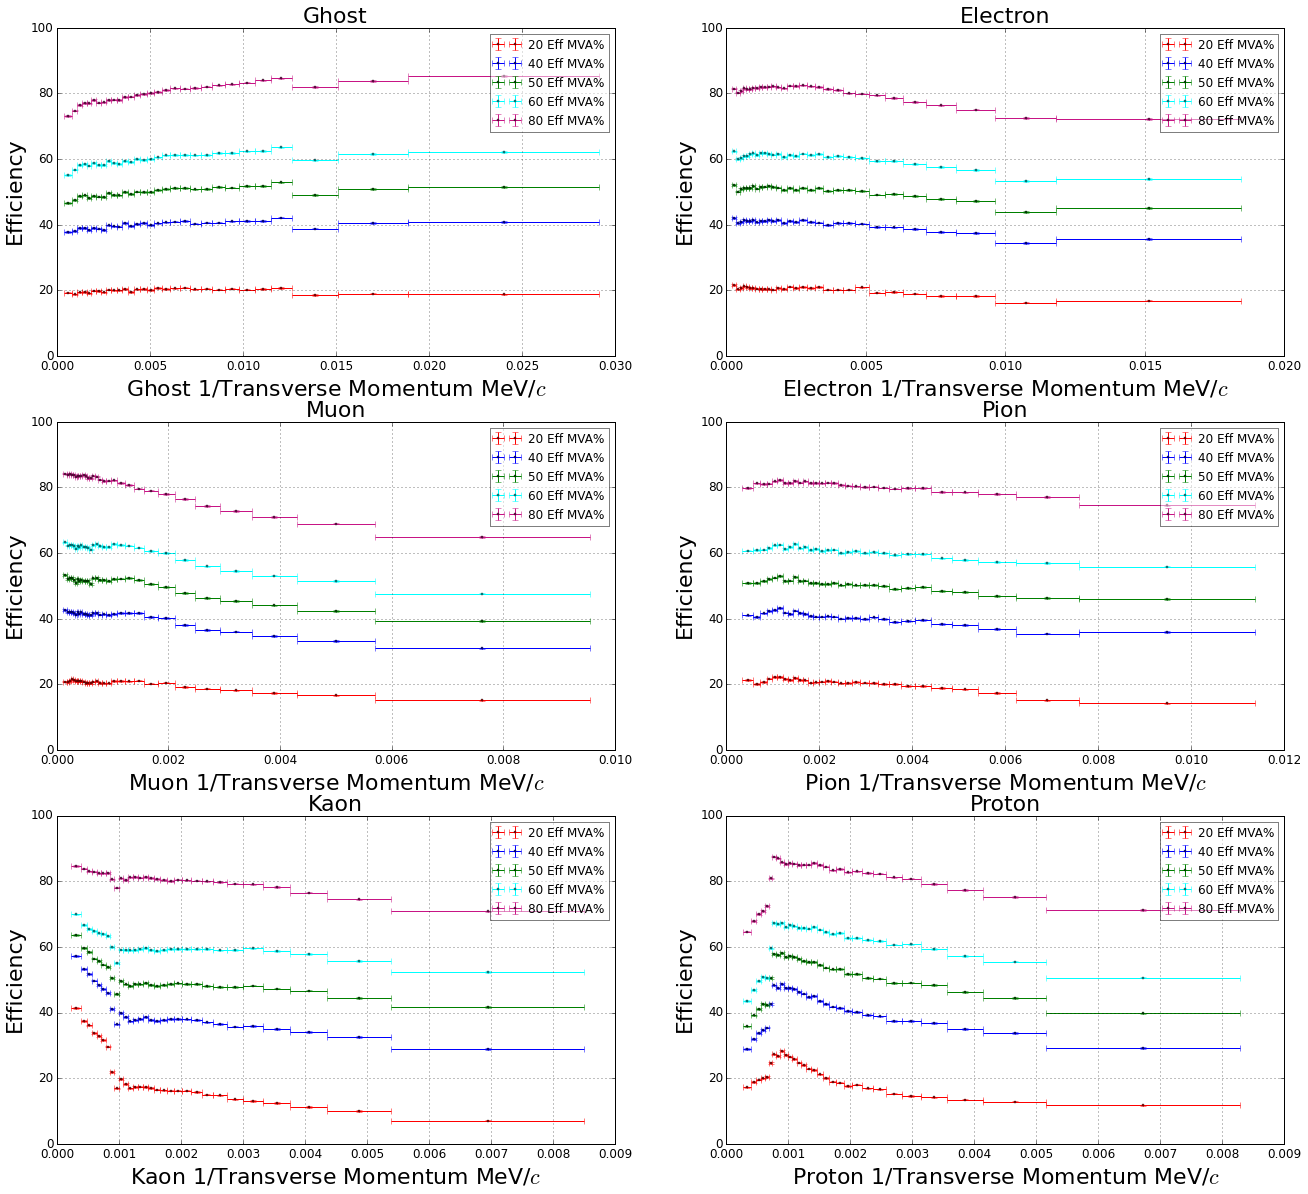

In [64]:
plot_flatness_by_particle(data_test.Signal.values, preds_2d, 1./data_test.TrackPt.values,
                          '1/Transverse Momentum MeV/$c$', thresholds=[20, 40, 50, 60, 80], 
                          weights=data_test.Weight.values, 
                          ignored_sideband=0.01)